# Methodological approach


### Models
- Baseline (TF-IDF + SVM with preprocessing): Train + Crossvalidation (default, 5-folds)
- Transformers: Validation is random sample of Train (10%). No cross-validation implemented yet, since not trivial

Both model classes use _class weights_ to address class imbalance problem and increase the effect on loss for minority classes. Uses the inverse of how many times a class is positive relative to negative, i.e. n_samples / (n_classes * np.bincount(y)

### Evaluation approach

    1) Train the models on the train set
    2) On each epoch, run evaluation with validation set and evaluation metric the Precision-Recall AuC
    3) Load at the end of training the model at the best performing epoch checkpoint.
    4) Do hyperparameter search and select the best model (of each model type)
    5) Predict the class labels for the __entire__ train set (so train + validation) and calculate the ROC/PR curves and AuC.
    6) Calculate the J-Stat (optimizing point in ROC space) and the F1 maximizing point in the Precision-Recall space
    7) Set class thresholds according to the F1 maximizing point
    8) Predict on the test set for model comparison (among model types)
    
### Scenarios

The following "scenarios" are defined:

- _optimistic_: Use only _positive_ labels for training, validation and test. This should give an "ceiling benchmark" of how good the _positive_ paragraphs can be separated/classified among themself.
- _efficient_realistic_: Use _Opportunities_ as _negative_ labels in training, use all negatives in test. 
- _realistic_: Use all negatives (opportunities, "weak" and "strong" from labelling process) for train and test.

| scenarios     | train           | test           |
| ------------- |:---------------:| --------------:|
| optimistic    | P: 279  N: 0    | P: 56   N:0    |
| efficient     | P: 279  N: 825  | P: 56 N: 28155 |
| realistic     | P: 279  N: 27533| P: 56 N: 28155 |

--> Note: Positives are counts of paragraphs with at least one positive label and negatives are those with all 0's.

### Tasks

- _binary_: Identification of CR relevant/irrelevant as baseline task. 
- _multi_label_cro_: Classification task of _Physical Risks_ and _Transition Risks_ with multi-labelling
- _multi_label_cro_sub_: Classification task of the 5 sub categories from _PR_ and _TR_

_multi_label_cro_sub_ is done as a second step after a _binary_ identification step. Train: All positives, Test: Overall Test dataset, where paragraphs that received a negative in the previous step are set to negative and included in the evaluation metrics to simulate a real word scenario, where the first step would act as a filter. Results are still pending here, since there seems to be an issue loading pretrained models https://github.com/huggingface/transformers/issues/8272.


# Results

Tables for each task below. As we know already, models perform well in the "naive" scenarios and bad once the negatives are considered. Performance improves once the full negative training data is provided. The relatively small and efficient distilbert-base-uncased performs best, beating the baseline but also roberta-large (in fact also other, bigger models. Needs certainly some investigation). Best PR AuC and F1-Score (at the threshold set according to the train results) for the test is at 48% for the binary task and at/below 40% for the 


# Questions

- Cross-validation with Transformers: What do we gain? More robust estimates of the validation metrics? Which model do we load at the end?
- Step 3 in Evaluation approach. For some models/scenarios, if more than 2-3 epochs are used, the eval loss starts increasing while the ROC-AuC/PR-AuC also increase, suggesting overfitting. Should we switch back to "loss" for best model selection?
- Step 4/5, selection of the thresholds: Is that o.k to run it on the entire train set? Alternative: Only validation set...

# Way forward (not in scope of the thesis)

- More data: Maybe we can invert the problem, e.g. consider the train/test set as test set, since there we have "negatives" (and as such a ground truth) and then start collecting training data (were we do not really have to have the ground truth)
- Revisit the paragraph approach: Split paragraphs in sentences
- Investigate labelled data after prediction, i.e. look at the most confusing examples etc to maybe find a pattern or label correction



In [54]:
print("Binary Task: ")
report_results(binary_df)

Binary Task: 


train           test  \
                                            epochs ROC AuC PR AuC ROC AuC   
scenario            model                                                   
optimistic          svm                        NaN   1.000  1.000   0.935   
                    distilbert-base-uncased    2.0   0.492  0.997   0.685   
                    roberta-large              2.0   0.760  0.999   0.157   
efficient-realistic svm                        NaN   0.999  0.994   0.868   
                    distilbert-base-uncased    NaN   0.993  0.987   0.950   
                    roberta-large              2.0   0.623  0.470   0.696   
realistic           svm                        NaN   0.999  0.977   0.984   
                    distilbert-base-uncased    2.0   0.986  0.859   0.988   
                    roberta-large              2.0   0.808  0.072   0.815   

                                                           
                                            PR AuC     F1  
scenario            model                                  
optimistic          svm                      0.998  0.920  
                    distilbert-base-uncased  0.985  0.982  
                    roberta-large            0.934  0.982  
efficient-realistic svm                      0.071  0.021  
                    distilbert-base-uncased  0.069  0.021  
                    roberta-large            0.007  0.004  
realistic           svm                      0.374  0.278  
                    distilbert-base-uncased  0.476  0.484  
                    roberta-large            0.025  0.000

In [55]:
print("Multilabel CR Task: ")
report_results(multilabel_df).sort_index(key=sort_second_idx, level="model", sort_remaining=False).sort_index(key=sort_first_idx, level="scenario", sort_remaining=False)

Multilabel CR Task: 


train           test  \
                                            epochs ROC AuC PR AuC ROC AuC   
scenario            model                                                   
optimistic          svm                        NaN   0.995  0.995   0.944   
                    distilbert-base-uncased    2.0   0.984  0.986   0.943   
                    roberta-large              2.0   0.982  0.985   0.959   
efficient-realistic svm                        NaN   0.999  0.989   0.911   
                    distilbert-base-uncased    2.0   0.986  0.950   0.947   
                    roberta-large              2.0   0.601  0.229   0.703   
realistic           svm                        NaN   1.000  0.972   0.982   
                    distilbert-base-uncased    2.0   0.986  0.836   0.980   
                    roberta-large              2.0   0.571  0.006   0.549   

                                                           
                                            PR AuC     F1  
scenario            model                                  
optimistic          svm                      0.959  0.741  
                    distilbert-base-uncased  0.958  0.865  
                    roberta-large            0.968  0.889  
efficient-realistic svm                      0.138  0.125  
                    distilbert-base-uncased  0.215  0.033  
                    roberta-large            0.011  0.006  
realistic           svm                      0.331  0.238  
                    distilbert-base-uncased  0.406  0.349  
                    roberta-large            0.001  0.000

Note: These ROC and P-R curves are the plots after training, on the entire TRAIN set and are used to find the optimal threshold values (dot).


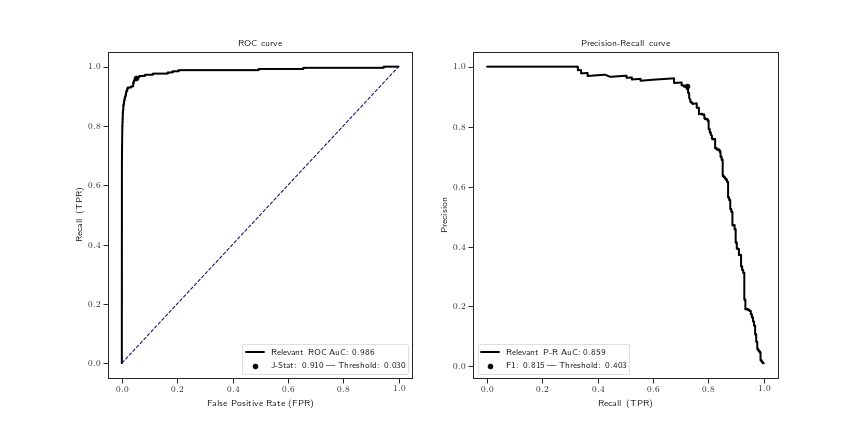

In [63]:
import os
from IPython.display import Image 

print("Note: These ROC and P-R curves are the plots after training, on the entire TRAIN set and are used to find the optimal threshold values (dot).")
path = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/results/figures/"
Image(filename = os.path.join(path, "cro_sub_type_combined_binary_realistic_distilbert-base-uncased_train_threshold.pdf.jpg"))

Confusion matrix on the test set...


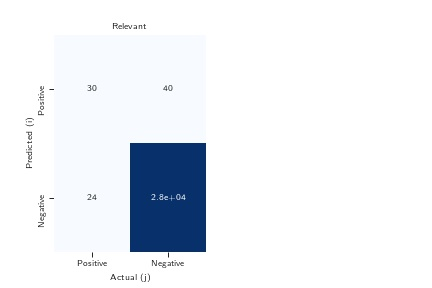

In [61]:
from IPython.display import Image 

print("Confusion matrix on the test set...")
path = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/results/figures/"
Image(filename = os.path.join(path, "cro_sub_type_combined_binary_realistic_distilbert-base-uncased_test_evaluation.pdf.jpg"))

In [53]:
import os
import re
import pandas as pd

RESULT_DIR = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/results"

try:
  import google.colab
  is_running_in_colab = True
except:
  is_running_in_colab = False
  
if is_running_in_colab:
  # Load Google drive where the data and models are stored
  from google.colab import drive
  drive.mount('/content/drive')
  RESULT_DIR = "/content/drive/MyDrive/fin-disclosures-nlp/results/"

scenarios = ["optimistic", "efficient-realistic", "realistic"]
models = ["svm", "distilbert-base-uncased", "roberta-large"]
prefixes = ['test', 'train'] # 'eval' would also be there, however overlapping 'eval_roc_auc', 'eval_pr_auc',
report_columns = ['epochs', 'train_ROC AuC', 'train_PR AuC', 'test_ROC AuC', 'test_PR AuC', 'test_F1']

def sort_first_idx(idx):
    mapper = {name: order for order, name in enumerate(scenarios)}
    return idx.map(mapper)

def sort_second_idx(idx):
    mapper = {name: order for order, name in enumerate(models)}
    return idx.map(mapper)

def report_results(df):
    df[['scenario', 'model']] = df.id.str.split('_', 1, expand=True)
    # Set the row multi-index
    df = df.set_index(['scenario', 'model'])
    df = df.sort_index(key=sort_second_idx, level="model", sort_remaining=False).sort_index(key=sort_first_idx, level="scenario", sort_remaining=False)
    
    df = df[[r for r in report_columns if r in df.columns ]]
    
    # Set the column multi-index
    first_lvl = []
    second_lvl = []
    for c in df.columns:
        splits = c.split("_", 1)
        first = splits[0] if splits[0] in prefixes else ""
        second = splits[1] if splits[0] in prefixes else c
        first_lvl.append(first)
        second_lvl.append(second)
    df.columns = [first_lvl, second_lvl]
    
    df = df.round(3)
    return df

binary_df = pd.read_csv(os.path.join(RESULT_DIR, "cro_sub_type_combined_binary_results.csv"))
multilabel_df = pd.read_csv(os.path.join(RESULT_DIR, "cro_multi-label_results.csv"))